# Sklonowanie i wejście do repozytorium



In [1]:
!git clone https://github.com/shizzeer/credo-classifier.git

Cloning into 'credo-classifier'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 68 (delta 28), reused 49 (delta 16), pack-reused 0
Receiving objects: 100% (68/68), 8.48 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
%cd credo-classifier

/content/credo-classifier


# Rozpakowanie danych treningowych

In [ ]:
!unzip images.zip

# Usunięcie klasy artefacts ze zbioru danych

In [4]:
!rm -r images/artefacts

# Zaimportowanie bibliotek

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import *
from tensorflow.keras.models import Sequential, save_model
from sklearn.model_selection import KFold
import pickle

# Module autoreloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Załadowanie zestawu danych treningowych i walidacyjnych


In [84]:
(train_ds, validation_ds) = load_dataset('./images/', batch_size=80, validation_split=0.3)

Found 1232 files belonging to 3 classes.
Using 863 files for training.
Found 1232 files belonging to 3 classes.
Using 369 files for validation.


# Podział zestawu walidacyjnego na zestaw walidacyjny oraz testowy w stosunku 20% do 10%

In [85]:
validation_batches = tf.data.experimental.cardinality(validation_ds)
# 10% test set
test_ds = validation_ds.take(validation_batches // 3)
# 20% validation set
validation_ds = validation_ds.skip(validation_batches // 3)

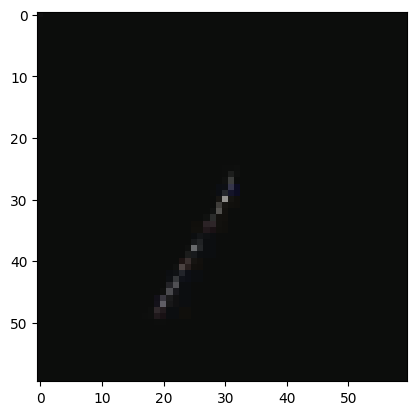

In [87]:
img_batch = test_ds.take(1)
batch_iterator = iter(img_batch)
image, label = next(batch_iterator)

plt.imshow(image[15].numpy().astype("uint8"))

In [70]:
np.count_nonzero(image[15].numpy().astype("uint8"))

1640

# Wykres przedstawiający rozkład ilości obrazów na klasę

Pod uwagę wzięty został zbiór danych treningowych

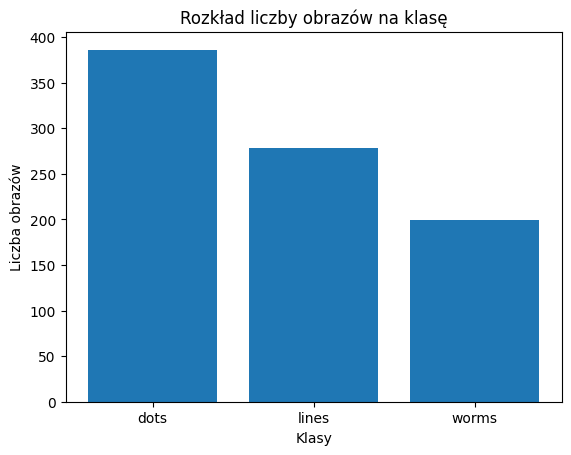

In [10]:
# Nazwy klas
class_names = train_ds.class_names

# Dla każdej nazwy klasy musimy mieć ilość sklasyfikowanych obrazow
class_members_count = {class_name: 0 for class_name in class_names}

for _, labels in train_ds:
  for label in labels.numpy():
    class_name = class_names[label]
    class_members_count[class_name] += 1

plt.bar(class_members_count.keys(), class_members_count.values())
plt.xlabel('Klasy')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład liczby obrazów na klasę')
plt.show()

# Preprocessing obrazów

Preprocessing jest na ten moment dokonywany w bardzo prosty aczkolwiek efektywny sposób. Każdy piksel obrazu jest podzielony przez 255 wskutek czego trafia on do zbioru wartości [0, 1].

Dzięki takiej operacji żadna cecha obrazu nie staje się ważniejsza podczas procesu trenowania modelu. W efekcie otrzymamy model, który będzie brał pod uwagę każdy piksel obrazu podczas jego przetwarzania.


In [ ]:
# preprocessed_images = []

# for images, labels in train_ds:
#   for image in images:
#     processed_image = preprocess_image(image)
#     preprocessed_images.append(processed_image)
#preprocessed_train_ds = train_ds.map(preprocess_image)
#preprocessed_validation_ds = validation_ds.map(preprocess_image)

# Model sieci konwolucyjnej (CNN)

Sieć konwolucyjna będzie zdefiniowana w stylu tzw. **feature pyramid**. Oznacza to, że z każdą kolejną warstwą konwolucyjną przestrzeń obrazu będzie się zmniejszać natomiast zwiększać się będzie ilość kanałów.

W ten sposób wczesne warstwy będą wykrywać proste cechy obrazu takie jak na przykład krawędzie natomiast dalsze warstwy będą wykrywać coraz to bardziej skomplikowane i abstrakcyjne cechy.

Z każdą kolejną warstwą idąc głębiej w sieć "oddalamy się" od szczegółów poprzez zmniejszanie przestrzeni obrazu, lecz zwiększamy ilość wykrywanych cech co powinno dać pożądany, opisany powyżej efekt.

Model będzie składał się z warstw:


*   Conv2D
*   MaxPooling2D
*   FC (Fully Connected Network)

## Preprocessing

Przed wprowadzeniem danych do sieci neuronowej w celu jej wytrenowania dane te są przetwarzane w taki sposób, aby ustabilizować proces treningu oraz zwiększyć możliwości generalizacji modelu.

Operacje, które przygotowują dane:

*    Rescaling - każdy piksel obrazu jest przeskalowany do zbioru [0, 1] co stabilizuje proces treningu modelu

*    Random horizontal and vertical flip - odbicie obrazu odpowiednio wzdłuż osi x oraz wzdłuż osi y. Odbicia są dokonywane losowo

*    Random rotation - losowe obrócenie obrazu w pewnym przedziale [-n% * 2pi, n% * 2pi] gdzie n to argument podany do warstwy

*    Random zoom - losowe powiększenie lub pomniejszenie się obrazu w przedziale [n%, n%] gdzie n to argument podany do warstwy







In [82]:
class CNNClasifier(tf.keras.Model):
  def __init__(self, num_filters=30, dense_units=20, num_classes=3):
    # Wywołanie konstruktora klasy nadrzędnej, czyli tf.keras.Model
    super().__init__()

    # Preprocessing
    self.preprocessing = Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.3)
    ])

    # Definicja warstw konwolucyjnych
    self.conv1 = tf.keras.layers.Conv2D(num_filters, # number of filters (30)
                                        3, # kernel size
                                        activation='relu',
                                        kernel_initializer="he_normal")

    self.max_pool1 = tf.keras.layers.MaxPooling2D(strides=2)

    self.conv2 = tf.keras.layers.Conv2D(num_filters*2, # number of filters (60)
                                        3, # kernel size
                                        activation='relu',
                                        kernel_initializer="he_normal")

    self.dropout1 = tf.keras.layers.Dropout(0.2)

    self.max_pool2 = tf.keras.layers.MaxPooling2D(strides=2)

    self.conv3 = tf.keras.layers.Conv2D(num_filters*3, # number of filters (90)
                                        3, # kernel size
                                        strides=(2,2),
                                        activation='relu',
                                        kernel_initializer="he_normal")

    self.dropout2 = tf.keras.layers.Dropout(0.4)

    self.flatten = tf.keras.layers.Flatten()

    self.dense1 = tf.keras.layers.Dense(dense_units,
                                       activation='relu',
                                       kernel_initializer="he_normal")

    self.dropout3 = tf.keras.layers.Dropout(0.3)

    self.dense2 = tf.keras.layers.Dense(dense_units*0.5,
                                        activation='relu',
                                        kernel_initializer="he_normal")

    self.output_layer = tf.keras.layers.Dense(num_classes,
                                              activation='linear')

    # self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                                      patience=20,
    #                                                      restore_best_weights=True)

  # Forward pass
  def call(self, inputs, training=False):
    x = self.preprocessing(inputs)
    x = self.conv1(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    if training:
      x = self.dropout1(x)
    x = self.max_pool2(x)
    x = self.conv3(x)
    if training:
      x = self.dropout2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    if training:
      x = self.dropout3(x)
    x = self.dense2(x)
    return self.output_layer(x)

# Trening i kompilacja modelu

In [ ]:
cnn_model = CNNClasifier()

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Zapisanie historii uczenia się modelu w celu wizualizacji wykresu funkcji straty od liczby epok
NUM_EPOCHS = 1500

history = cnn_model.fit(train_ds,
    batch_size=80,
    epochs=NUM_EPOCHS,
    validation_data=validation_ds)
    # callbacks=[cnn_model.early_stopping])

In [ ]:
tf.data.experimental.cardinality(validation_ds)
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=11>

# Zapisanie lub wczytanie historii wytrenowanego modelu

In [ ]:
with open('model_train_history', 'wb') as pickle_f:
  pickle.dump(history.history, pickle_f)

In [ ]:
with open('model_train_history', 'rb') as pickle_f:
  history = pickle.load(pickle_f)

# Załadowanie wytrenowanego modelu

Ta sekcja powinna być używana tylko i wyłącznie wtedy kiedy posiadamy zapisaną architekturą, wagi oraz stan optymalizatora wcześniej wytrenowanego modelu. Wówczas pomija się trening i używa dopasowanego modelu do dokonywania klasyfikacji obrazów

In [91]:
from tensorflow.keras.models import load_model
cnn_model = load_model('cnn_model')

# Ocena jakości klasyfikacji modelu

Ocena jakości modelu została dokonana za pomocą metody k-fold. Zbiór danych treningowych został podzielony na 5 równych części. Każda z tych części podczas jednej z pięciu iteracji pełniła rolę zbioru walidacyjnego. Model został wytrenowany dokładnie pięć razy za każdym razem z innym podziałem danych na treningowe i walidacyjne. Na koniec została policzona średnia z pięciu ocen jego jakości. Dzięki temu ocena jakości modelu nie jest zależna od pojedynczego podziału zbioru danych na zestaw treningowy i walidacyjny.

In [88]:
# Konwertowanie datasetów do tablicy numpy
train_images = np.concatenate(list(train_ds.map(lambda img, label: img)))
train_labels = np.concatenate(list(train_ds.map(lambda x, y: y)))
validation_images = np.concatenate(list(validation_ds.map(lambda x, y: x)))
validation_labels = np.concatenate(list(validation_ds.map(lambda x, y: y)))

print('Train images shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Validation images shape: ', validation_images.shape)
print('Validation labels shape: ', validation_labels.shape)

Train images shape:  (863, 60, 60, 3)
Train labels shape:  (863,)
Validation images shape:  (289, 60, 60, 3)
Validation labels shape:  (289,)


In [89]:
# Połączenie ze sobą zestawu treningowego oraz walidacyjnego
inputs = np.concatenate((train_images, validation_images), axis=0)
targets = np.concatenate((train_labels, validation_labels), axis=0)

print('Inputs shape: ', inputs.shape)
print('Targets shape: ', targets.shape)

Inputs shape:  (1152, 60, 60, 3)
Targets shape:  (1152,)


# K-fold cross validation

Dla k = 5

In [90]:
NUM_EPOCHS = 1500
# Założenie bazowe dla modelu -> zbiór walidacyjny stanowi 20% zbioru treningowego
num_of_folds = 5
k_fold = KFold(n_splits=num_of_folds, shuffle=True)

accuracy_scores = []
losses = []

for fold, (train, val) in enumerate(k_fold.split(inputs, targets)):
  print(f"Fold {fold + 1}/{num_of_folds}")

  cnn_model = CNNClasifier()

  # Wyzerowanie wag modelu
  cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  print('Training shape: ', inputs[train].shape)
  print('Validation shape: ', inputs[val].shape)

  cnn_model.fit(inputs[train],
                targets[train],
                batch_size=80,
                epochs=NUM_EPOCHS,
                validation_data=(inputs[val], targets[val]))

  loss, accuracy_score = cnn_model.evaluate(inputs[val], targets[val])
  accuracy_scores.append(accuracy_score)
  losses.append(loss)

score = np.mean(accuracy_scores)
mean_loss = np.mean(losses)
print(f"Validation score: {score}")
print(f"Validation loss: {mean_loss}")

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
12/12 [==============================] - 0s 20ms/step - loss: 0.1240 - accuracy: 0.9501 - val_loss: 0.1296 - val_accuracy: 0.9391
Epoch 505/1500
12/12 [==============================] - 0s 19ms/step - loss: 0.1319 - accuracy: 0.9479 - val_loss: 0.1088 - val_accuracy: 0.9609
Epoch 506/1500
12/12 [==============================] - 0s 20ms/step - loss: 0.1270 - accuracy: 0.9534 - val_loss: 0.1978 - val_accuracy: 0.9261
Epoch 507/1500
12/12 [==============================] - 0s 21ms/step - loss: 0.1267 - accuracy: 0.9501 - val_loss: 0.1851 - val_accuracy: 0.9435
Epoch 508/1500
12/12 [==============================] - 0s 19ms/step - loss: 0.1276 - accuracy: 0.9523 - val_loss: 0.1461 - val_accuracy: 0.9522
Epoch 509/1500
12/12 [==============================] - 0s 20ms/step - loss: 0.1195 - accuracy: 0.9544 - val_loss: 0.1799 - val_accuracy: 0.9304
Epoch 510/1500
12/12 [==============================] - 0s 19ms/step - loss: 0.1

In [92]:
test_ds_eval = cnn_model.evaluate(test_ds)
print("Test Set - Loss:", test_ds_eval[0], "Accuracy:", test_ds_eval[1])

1/1 [==============================] - 0s 165ms/step - loss: 0.2853 - accuracy: 0.9375
Test Set - Loss: 0.2852875590324402 Accuracy: 0.9375


# Wykres funkcji straty od liczby epok

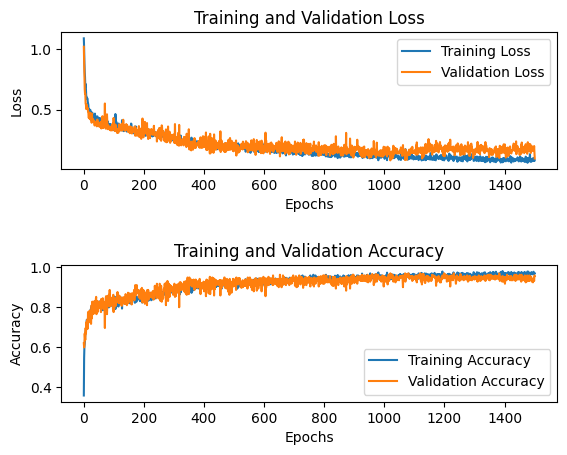

In [ ]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, NUM_EPOCHS + 1)

fig, arr = plt.subplots(2, 1)
arr[0].plot(epochs, train_loss, label='Training Loss')
arr[0].plot(epochs, validation_loss, label='Validation Loss')
arr[0].set_title('Training and Validation Loss')
arr[0].set_xlabel('Epochs')
arr[0].set_ylabel('Loss')
arr[0].legend()

plt.subplots_adjust(hspace=0.7)

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
arr[1].plot(epochs, train_acc, label='Training Accuracy')
arr[1].plot(epochs, validation_acc, label='Validation Accuracy')
arr[1].set_title('Training and Validation Accuracy')
arr[1].set_xlabel('Epochs')
arr[1].set_ylabel('Accuracy')
arr[1].legend()

In [ ]:
cnn_model.summary()

Model: "cnn_clasifier_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 60, 60, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           multiple                  840       
                                                                 
 max_pooling2d_6 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          multiple                  16260     
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 max_pooling2d_7 (MaxPoolin  multiple                  0         
 g2D)                                              

# Klasyfikacja za pomocą wytrenowanego modelu

Klasyfikacja na zestawie testowym

In [ ]:
#test_ds = test_ds.map(lambda x, y: (x / 255.0, y))
images, labels = next(iter(test_ds))

# Make predictions for the batch
predictions = cnn_model.predict(images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

rows = 4
cols = 3
fig = plt.figure(figsize=(15,15))
img_idx = 0

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(image[img_idx].numpy().astype("uint8"))
    plt.title(f"True: {labels[img_idx].numpy()}\nPredicted: {predicted_labels[img_idx]}")
    plt.axis('off')
    img_idx += 1
plt.show()

# Zapisanie modelu w formacie SavedModel

Zapisanie modelu obejmuje:


*   Zapis architektury
*   Zapis wag
*   Zapis funkcji straty
*   Zapis stanu optimizera

Po ponownym załadowaniu modelu ze stworzonego katalogu będziemy mieć model gotowy do dokonywania przewidywań


In [ ]:
cnn_model.save('cnn_model')

In [ ]:
!cp ../drive/MyDrive/Colab\ Notebooks/credo_image_classifier.ipynb .

In [ ]:
!rm -r images

In [ ]:
!git config --global user.email "eronics00@gmail.com"
!git config --global user.name "Kamil Szpakowski"
#!git status
#!git add *
#!git commit -m "Predictions plot added"

The following paths are ignored by one of your .gitignore files:
__pycache__
hint: Use -f if you really want to add them.
hint: Turn this message off by running
hint: "git config advice.addIgnoredFile false"
[main 78a9c49] Predictions plot added
 2 files changed, 3 insertions(+), 3 deletions(-)
 rewrite credo_image_classifier.ipynb (95%)
